# Data Import

In [ ]:
np.random.seed(42)


num_patients = 100
num_events = 1080
start_date = pd.Timestamp('2030-07-06')
end_date = pd.Timestamp('2044-09-03')
patient_ids = np.random.choice(range(1, num_patients + 1), num_events)
date_range = (end_date - start_date).days
event_dates = [
    start_date + pd.Timedelta(days=np.random.randint(0, date_range))
    for _ in range(num_events)
]
daily_dosages = np.random.randint(2, 21, num_events)
medication_types = np.random.choice(['medA', 'medB'], num_events)
durations = np.random.randint(20, 151, num_events)

med_events = pd.DataFrame({
    'PATIENT_ID': patient_ids,
    'DATE': event_dates,
    'PERDAY': daily_dosages,
    'CATEGORY': medication_types,
    'DURATION': durations
})

df_estimated_hier = sessa_empirical_estimator_hier(med_events, chosen_category="medA", cut_ecdf=0.8)
...


<ipython-input-3-f19e7aa44cdd>:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dsub = dsub.groupby("PATIENT_ID", group_keys=False).apply(lambda x: x.sample(n=1, random_state=42))


Ellipsis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from datetime import datetime, timedelta



def sessa_empirical_estimator(df, chosen_category="medA", cut_ecdf=0.8):


    dsub = df[df["CATEGORY"] == chosen_category].copy()
    if dsub.empty:
        print(f"No rows found for category={chosen_category}")
        return None


    dsub.sort_values(by=["PATIENT_ID", "DATE"], inplace=True)

    dsub["prev_DATE"] = dsub.groupby("PATIENT_ID")["DATE"].shift(1)
    dsub.dropna(subset=["prev_DATE"], inplace=True)  
    dsub["event_interval"] = (dsub["DATE"] - dsub["prev_DATE"]).dt.days

    dsub = dsub.groupby("PATIENT_ID", group_keys=False).apply(lambda x: x.sample(n=1, random_state=42))

    intervals_sorted = np.sort(dsub["event_interval"].values)
    if len(intervals_sorted) < 2:
        print("Not enough intervals to build an ECDF.")
        return None

    cutoff_index = int(len(intervals_sorted) * cut_ecdf)
    cutoff_index = max(cutoff_index, 1)  
    max_interval_kept = intervals_sorted[cutoff_index - 1]

    dsub_in = dsub[dsub["event_interval"] <= max_interval_kept].copy()
    dsub_out = dsub[dsub["event_interval"] > max_interval_kept].copy()

    if dsub_in.empty:
        print("All intervals were above the cutoff, cannot cluster.")
        return None


    X = dsub_in["event_interval"].values.reshape(-1, 1)
    best_k = 2
    best_score = -1
    for k in range(2, 7):
        km = KMeans(n_clusters=k, random_state=42).fit(X)
        labels = km.labels_
        score = silhouette_score(X, labels)
        if score > best_score:
            best_k = k
            best_score = score


    km_final = KMeans(n_clusters=best_k, random_state=42).fit(X)
    labels_final = km_final.labels_
    dsub_in["cluster"] = labels_final

    median_map = dsub_in.groupby("cluster")["event_interval"].median().to_dict()

    dsub_in["median_interval"] = dsub_in["cluster"].map(median_map)

    if not dsub_out.empty:
        cluster_sizes = dsub_in["cluster"].value_counts()
        biggest_cluster = cluster_sizes.index[0] 
        biggest_median = median_map[biggest_cluster]
        dsub_out["cluster"] = biggest_cluster
        dsub_out["median_interval"] = biggest_median

    df_result = pd.concat([dsub_in, dsub_out], axis=0)
    df_result.sort_values(["PATIENT_ID", "DATE"], inplace=True)

    return df_result



# SEE-Hierarchical Function

In [ ]:
def sessa_empirical_estimator_hier(df, chosen_category="medA", cut_ecdf=0.8):

    dsub = df[df["CATEGORY"] == chosen_category].copy()
    if dsub.empty:
        print(f"No rows found for category={chosen_category}")
        return None

    dsub.sort_values(by=["PATIENT_ID", "DATE"], inplace=True)
    dsub["prev_DATE"] = dsub.groupby("PATIENT_ID")["DATE"].shift(1)
    dsub.dropna(subset=["prev_DATE"], inplace=True)
    dsub["event_interval"] = (dsub["DATE"] - dsub["prev_DATE"]).dt.days

    dsub = dsub.groupby("PATIENT_ID", group_keys=False).apply(lambda x: x.sample(n=1, random_state=42))

    intervals_sorted = np.sort(dsub["event_interval"].values)
    if len(intervals_sorted) < 2:
        print("Not enough intervals to build an ECDF.")
        return None

    cutoff_index = int(len(intervals_sorted) * cut_ecdf)
    cutoff_index = max(cutoff_index, 1)
    max_interval_kept = intervals_sorted[cutoff_index - 1]

    dsub_in = dsub[dsub["event_interval"] <= max_interval_kept].copy()
    dsub_out = dsub[dsub["event_interval"] > max_interval_kept].copy()

    if dsub_in.empty:
        print("All intervals were above the cutoff, cannot cluster.")
        return None

    X = dsub_in["event_interval"].values.reshape(-1, 1)

    best_k = 2
    best_score = -1
    for k in range(2, 7):
        agg = AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_k = k
            best_score = score

    agg_final = AgglomerativeClustering(n_clusters=best_k)
    labels_final = agg_final.fit_predict(X)
    dsub_in["cluster"] = labels_final

    median_map = dsub_in.groupby("cluster")["event_interval"].median().to_dict()
    dsub_in["median_interval"] = dsub_in["cluster"].map(median_map)

    if not dsub_out.empty:
        cluster_sizes = dsub_in["cluster"].value_counts()
        biggest_cluster = cluster_sizes.index[0]
        biggest_median = median_map[biggest_cluster]
        dsub_out["cluster"] = biggest_cluster
        dsub_out["median_interval"] = biggest_median

    df_result = pd.concat([dsub_in, dsub_out], axis=0).sort_values(["PATIENT_ID", "DATE"])
    return df_result


In [ ]:

df_estimated_hier = sessa_empirical_estimator_hier(med_events, chosen_category="medA", cut_ecdf=0.8)
print(df_estimated_hier.head(10))

if df_estimated_hier is not None:
    print("Unique clusters found:", df_estimated_hier["cluster"].unique())


     PATIENT_ID       DATE  PERDAY CATEGORY  DURATION  prev_DATE  \
290           1 2043-02-24       2     medA        92 2042-08-14   
223           2 2034-07-26      16     medA        25 2033-12-05   
740           3 2036-02-08       4     medA       132 2035-12-21   
75            4 2033-01-13      14     medA        29 2033-01-07   
814           5 2036-12-17      19     medA        36 2035-07-03   
73            6 2031-10-26      11     medA        86 2031-03-07   
334           7 2043-08-15      18     medA       110 2039-07-13   
347           8 2041-11-15      10     medA        77 2041-08-01   
406           9 2041-06-08       9     medA       115 2032-12-08   
885          10 2040-12-14      12     medA       112 2037-09-19   

     event_interval  cluster  median_interval  
290             194        0            251.0  
223             233        0            251.0  
740              49        0            251.0  
75                6        0            251.0  
814        

<ipython-input-8-f19e7aa44cdd>:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dsub = dsub.groupby("PATIENT_ID", group_keys=False).apply(lambda x: x.sample(n=1, random_state=42))


# Compare K-Means and Hierarchical on the Final “event_interval”



K-Means best cluster count on 'event_interval': 3, silhouette=0.688
Hierarchical best cluster count on 'event_interval': 4, silhouette=0.693


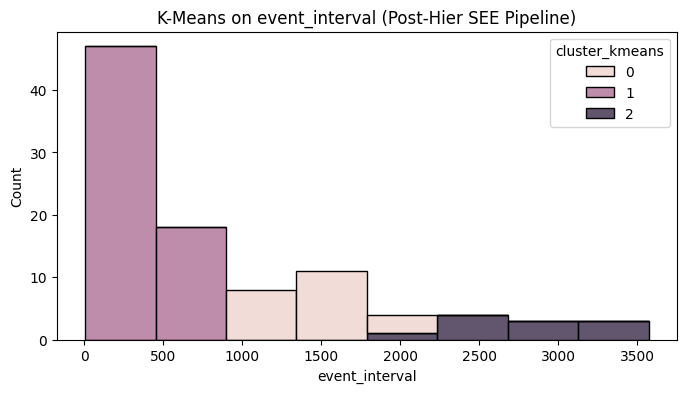

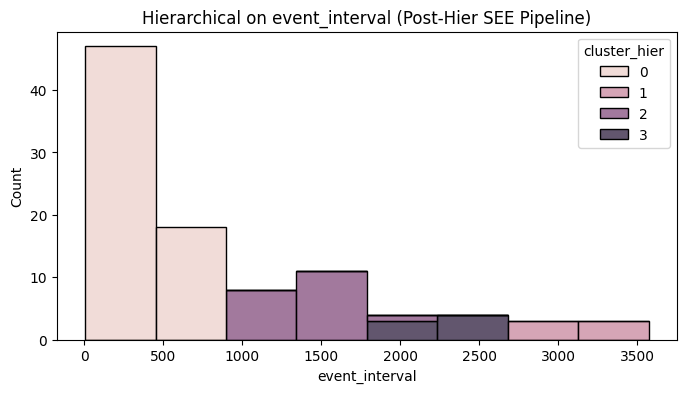

In [ ]:
if df_estimated_hier is not None:
    df_clust_h = df_estimated_hier.dropna(subset=["event_interval"]).copy()

    X_h = df_clust_h["event_interval"].values.reshape(-1,1)

    best_k_km = 2
    best_score_km = -1
    for k in range(2,7):
        km = KMeans(n_clusters=k, random_state=42).fit(X_h)
        labels_km = km.labels_
        score_km = silhouette_score(X_h, labels_km)
        if score_km > best_score_km:
            best_score_km = score_km
            best_k_km = k

    final_km = KMeans(n_clusters=best_k_km, random_state=42).fit(X_h)
    df_clust_h["cluster_kmeans"] = final_km.labels_

    print(f"\nK-Means best cluster count on 'event_interval': {best_k_km}, silhouette={best_score_km:.3f}")

    best_k_h2 = 2
    best_score_h2 = -1
    for k in range(2,7):
        agg = AgglomerativeClustering(n_clusters=k)
        labels_agg = agg.fit_predict(X_h)
        score_agg = silhouette_score(X_h, labels_agg)
        if score_agg > best_score_h2:
            best_k_h2 = k
            best_score_h2 = score_agg

    final_agg2 = AgglomerativeClustering(n_clusters=best_k_h2)
    df_clust_h["cluster_hier"] = final_agg2.fit_predict(X_h)

    print(f"Hierarchical best cluster count on 'event_interval': {best_k_h2}, silhouette={best_score_h2:.3f}")
    
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_clust_h, x="event_interval", hue="cluster_kmeans", multiple="stack", kde=False)
    plt.title("K-Means on event_interval (Post-Hier SEE Pipeline)")
    plt.show()

    plt.figure(figsize=(8,4))
    sns.histplot(data=df_clust_h, x="event_interval", hue="cluster_hier", multiple="stack", kde=False)
    plt.title("Hierarchical on event_interval (Post-Hier SEE Pipeline)")
    plt.show()


# Key Insights:
- Clusters (K-Means)
    - 3 clusters which consist of Cluster 0 (short intervals: most patients refilling under ~500days),1 (medium intervals: ~500-1000 or 1500),and 2 (very large intervals: above ~1500 or 2000)
    - Made all intervals ~1000-1500 days into a single group

- Clusters (Hierarchical)
    - 4 clusters which consist of Cluster 0 (very short intervals < 500 days>),1 (moderate intervals ~500-1000),2 (larger intervals 1000-2000),3 (most extreme intervals 2000+days)
    - Splitted the longest intervals into a separate group

- How do they group the cluster differently?
    - K-means: tries to minimize variance from each cluster centroid, so it decided that 3 centroids was sufficient
    - Hierarchical: merges intervals step by step, and it found a slightly better sillhouette by splitting those long intervals into 2 subgroups.

- Comparison of Silhouette Scores
    - Hierarchical showed slightly higher score: 0.693 than K-means':0.688
    - The gap is small so both partitions/algorithms are fairly good